In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import sklearn.metrics as metrics
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold as KF

from sklearn.ensemble import RandomForestClassifier
from catboost import Pool, CatBoostClassifier
import xgboost
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb
# from tabpfn import TabPFNClassifier

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
BASE_PATH = '/kaggle/input/icr-identify-age-related-conditions'
df_test = pd.read_csv(f'{BASE_PATH}/test.csv')
df_train = pd.read_csv(f'{BASE_PATH}/train.csv')
df_greeks = pd.read_csv(f'{BASE_PATH}/greeks.csv')
sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [3]:
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
df_greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
df_train_meta = df_train.merge(df_greeks, how='inner', on='Id')

There is a large class imbalance. We have two (simple) options:
* Undersample so the full sample size is 216 (108 class_0 and 108 class_1)
* Oversample on Alpha, so that full sample size is 2036 (509 of each class)

In [6]:
print(df_train.Class.value_counts())
print(df_train_meta.Alpha.value_counts())

0    509
1    108
Name: Class, dtype: int64
A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64


In [7]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,615.000000,614.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525,77.104151,0.688801,90.251735,11.241064,0.030615,1.403761,0.742262,36.917590,1.383792,27.165653,51.128326,401.901299,0.633884,0.367002,146.972099,94.795377,26.370568,1.802900,1.924830,26.388989,9.072700,3.064778,1731.248215,0.305107,69.582596,105.060712,69.117005,71.341526,6.930086,10306.810737,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275,159.049302,0.263994,51.585130,13.571133,0.014808,1.922210,0.281195,17.266347,0.538717,14.645993,21.210888,317.745623,1.912384,0.112989,86.084419,28.243187,8.038825,9.034721,1.484555,18.116679,6.200281,2.058344,1790.227476,1.847499,38.555707,68.445620,390.187057,165.551545,64.754262,11331.294051,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377,23.317567,0.563688,64.724192,5.066306,0.023482,1.050225,0.589575,29.782467,1.070298,7.030640,37.942520,188.815690,0.238680,0.295164,102.703553,78.232240,20.888264,0.005518,1.743070,14.715792,5.965392,1.648679,1111.160625,0.003042,30.927468,78.526968,4.324656,25.815384,0.296850,5164.666260,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377,42.554330,0.658715,79.819104,9.123000,0.027860,1.050225,0.730800,34.835130,1.351665,36.019104,49.180940,307.509595,0.238680,0.358023,130.050630,96.264960,25.248800,0.251741,1.743070,21.642456,8.149404,2.616119,1493.817413,0.085176,71.949306,78.526968,22.641144,36.394008,1.870155,7345.143424,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377,77.310097,0.772206,99.813520,13.565901,0.034427,1.228445,0.859350,40.529401,1.660617,37.935832,61.408760,507.896200,0.238680,0.426348,165.836955,110.640680,30.544224,1.058690,1.743070,34.058344,10.503048,3.910070,1905.701475,0.237276,109.125159,112.766654,49.085352,56.714448,4.88021

### $\text{LogLoss} = \dfrac{-\frac{1}{N_0}\sum_{i=1}^{N_0}y_{0i}\log{p_{0i}}-\frac{1}{N_1}\sum_{i=1}^{N_1}y_{1i}\log{p_{1i}}}{2}$

In [8]:
def bal_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

In [9]:
# optionally create synthetic features by taking 2-interactions
def get_interactions(df):
    new_cols = []
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2: continue
            if col1 in ['Id', 'Class', 'EJ', 'rng', 'Alpha']: continue
            if col2 in ['Id', 'Class', 'EJ', 'rng', 'Alpha']: continue
            col3 = '_'.join([col1, col2])
            new_col = pd.Series(df[col1]*df[col2], name=col3)
            new_cols.append(new_col)
    return pd.concat([df] + new_cols, axis=1)
        
def clean_EJ(x):
    if x == 'A': return 1
    if x == 'B': return 0
    return x 


The below class handles cleaning, fitting, and ensembling of models

In [10]:
class Learner:
    
    def __init__(
        self, 
        interactions=False, 
        scaler='minmax',
        features=None
    ):
        self.interactions = interactions
        self.scaler = None
        self.imputer = None
        
        if scaler == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler == 'box-cox':
            self.scaler = PowerTransformer(method='box-cox', standardize=False)
        elif scaler == 'yeo':
            self.scaler = PowerTransformer(method='yeo-johnson', standardize=False)
        elif scaler == 'quantile':
            self.scaler = QuantileTransformer(output_distribution='normal', random_state=0)
        elif scaler == 'standard':
            self.scaler = StandardScaler()
        elif scaler is None:
            self.scaler = None
        else:
            raise ValueError('provide a valid scaler')
            
        self.imputer = KNNImputer(n_neighbors=5, weights='uniform')
        self.rus = RandomUnderSampler(random_state=0)
        self.features = features
        self.clfs = [
            lgb.LGBMClassifier(), 
#             TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0'),
#             CatBoostClassifier(),
            RandomForestClassifier(),
        ]
    
    def fit(self, X, y):
        X = self.preprocess(X, is_fitting=True)
        # X_resampled, y_resampled = self.rus.fit_resample(X, y)
        
        for i, clf in enumerate(self.clfs):
            if i == 0:
                X = pd.DataFrame(X, columns=self.features)
            clf.fit(X, y)
    
    def predict(self, X, round_class=True, threshold=0.85):
        X = self.preprocess(X)
        probs = np.stack([clf.predict_proba(X) for clf in self.clfs])
        averaged_probabilities = np.mean(probs, axis=0)
        
        # we reweight the probs, since the loss is also balanced like this
        # our models out of the box optimize CE
        # with these changes they optimize balanced CE
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        out_probs = new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)
        out_probs = out_probs[:,1]
        
        if round_class:
            out_probs[out_probs >= threshold] = 1
            out_probs[out_probs < 1-threshold] = 0
        
        return out_probs
        
    def preprocess(self, X, is_fitting=False):
        n = len(X)
        
        X.EJ = X.EJ.map(clean_EJ)
        if self.interactions:
            X = get_interactions(X)
            
        if self.features is None:
            self.features = X.columns
        else:
            X = X[self.features]
            
        if is_fitting:
            X = self.scaler.fit_transform(X)
            X = self.imputer.fit_transform(X)
        else:
            X = self.scaler.transform(X)
            X = self.imputer.transform(X)
        assert len(X) == n
        return X
    

Uses K-fold cross-validation to train the model over 10 folds and return the best scoring one

In [11]:
def train(model, X, y):
    splits = 7
    cv = KF(n_splits=splits, shuffle=True, random_state=42)
    min_loss = np.inf
    
    for train_idx, val_idx in tqdm(cv.split(X), total=splits):
        
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_val)
        m_loss = bal_log_loss(y_val, y_pred)
        
        print(f'Model loss: {m_loss}')
        if m_loss < min_loss:
            best_model = model
            min_loss = m_loss
        
    return best_model

Add a random noise feature `rng`. Any feature with less importance is discarded

In [12]:

feature_style = 'best_singles'

# df_train['rng'] = np.random.rand(len(df_train))
interactions = False

if feature_style == 'best_singles':
    train_cols = [
              'AB', 'DU', 'BQ', 'CR', 'DL', 'EE', 'EJ',
              'DA', 'CC', 'FR', 'AF', 'FI', 'DE', 'AX',
              'EB', 'DY', 'FE', 'DN', 'FL', 'EP', 'EU',
              'AM', 'CD ', 'DI', 'GL', 'BN', 'FS', 'DH',
            ]
    interactions = False
elif feature_style == 'all':
    train_cols = [col for col in df_train.columns if col not in ['Id', 'Class']]
elif feature_style == 'best_interactions':
    train_cols = ['CR_DH','CR','AB_EL','DU_FR','BP_DU','AB',
              'EE_FS','CR_DL','AB_DU','CR_DA','CC_DA','DU_FL',
              'DL_DU','DE_EE','AB_BP','AB_GL','BQ_DY','BD ',
              'AB_BQ','BQ_DF','CU_DE','BP_EU','DA_GH','AF',
              'AF_EU','CH_DA','BC_FE','AB_CS','BC_EP','AB_DI',
              'FE_FL','AB_BZ','DE_FS','DL','CD _EE','AR_EB',
              'FL_FR','BQ_GH','EE_FL','BC_BQ','AF_BC','AB_BD ',
              'EG_EP','CC_FS','BC_DU','DI_DU','CC_CR','CD _GL',
              'CS_DA','AB_BC','CU_GE','AF_DV','CC_CH','AB_CL',
              'AX','DE','AX_BQ','DL_EL','CD ','BC_DY','AX_EG',
              'BP','EE','EE_EP','DY_EU','AZ','EE_EL','CF_EU',
              'AB_FE','BD _EP','CC_GE','CC_DH','DA_DL','DA_EP',
              'DU_EB','AB_AF','BQ_EH','AB_EB','AB_GB','BQ_CD ',
              'AX_FI','AX_EP','AF_EL','EG_FC','BP_DF','DF_DY',
              'DF_DI','BC_GL','BR_DU','CS_DE','AY_DY','AX_GL',
              'AX_BC','DU_FE','CB_DU','CD _DA','CD _DU','AF_DF',
              'CS_EL','DH_DL']
    interactions = True


Oversamples the data such that there are an equal number of each class A, B, C, D.

This means that there will still be an imbalance as only 25% will be of class 1.

In [13]:

# Resample the 'train_pred_and_time' dataframe and 'greeks.Alpha' series using RandomOverSampler
# The resampled data is assigned to 'train_ros' and 'y_ros' respectively
df_train_meta = df_train.merge(df_greeks[['Id', 'Alpha']], how='inner', on='Id')
ros = RandomOverSampler(random_state=42)
df_train_ros, y_ros = ros.fit_resample(df_train_meta, df_train_meta.Alpha)

print(df_train_meta.Alpha.value_counts())
print(df_train_ros.Alpha.value_counts())

A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64
B    509
A    509
D    509
G    509
Name: Alpha, dtype: int64


In [14]:
X = df_train_ros#[train_cols]
y = df_train_ros.Class

learner = Learner(interactions=interactions, features=train_cols)
model = train(learner, X, y)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.007588871203841574


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.01087899306666074


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.005132520247302926


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.0077583329903652565


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.008461427529077187


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model loss: 0.004766160236440224
Model loss: 0.004984538310384713


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


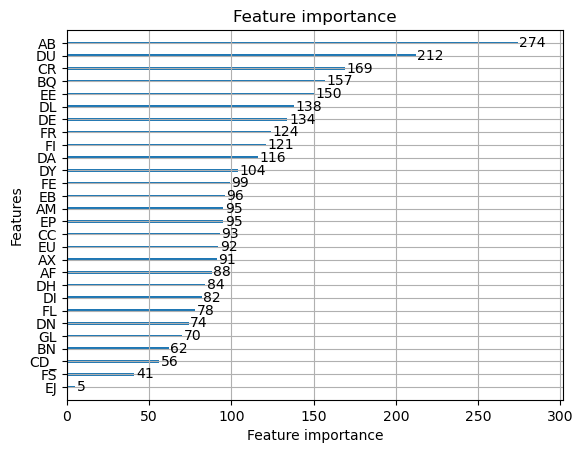

In [15]:
lgb.plot_importance(model.clfs[0])
df_feature_imp = pd.DataFrame({'Value':model.clfs[0].feature_importances_,'Feature':model.features}).sort_values(by="Value",ascending=False).reset_index(drop=True)

In [16]:
if 'rng' in df_feature_imp.Feature.values:
    useful_features = df_feature_imp[:df_feature_imp[(df_feature_imp.Feature=='rng')].index[0]].Feature.values
    print("['{}']".format("','".join(useful_features)))

In [17]:
y_pred = model.predict(X, threshold=0.9)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [18]:
print(classification_report(y, y_pred > 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00      1527

    accuracy                           1.00      2036
   macro avg       1.00      1.00      1.00      2036
weighted avg       1.00      1.00      1.00      2036



explained_variance: 100.0%
R2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0

Bal Log Loss:  0.0
[[ 509    0]
 [   0 1527]]


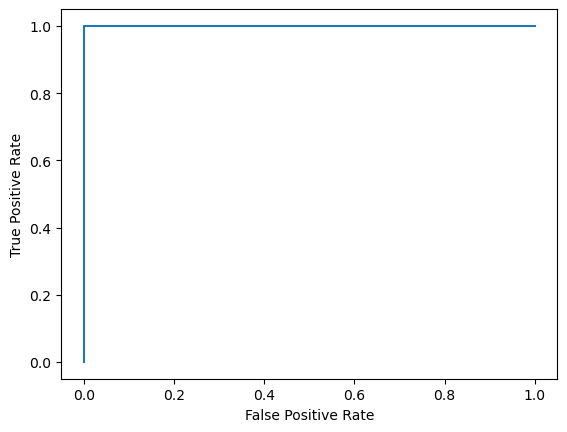

In [19]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    bll = bal_log_loss(y_true, y_pred)

    print('explained_variance: {}%'.format(round(explained_variance*100,2)))    
    print('R2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print()
    print('Bal Log Loss: ', round(bll,4))

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
regression_results(y, y_pred > 0.5)
plot_roc_curve(y, y_pred > 0.5)
cf_mat = confusion_matrix(y, y_pred > 0.5)
print(cf_mat)

In [20]:
df_out = df_test.Id.to_frame()
y_pred = model.predict(df_test)
# y_pred = model.predict(df_test.drop(['Id'], axis=1))
df_out['class_0'] = 1-y_pred
df_out['class_1'] = y_pred

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [21]:
df_out

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [22]:
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [23]:
df_out.to_csv('submission.csv', index=False)